#Instructions & Environment Set Up

Before running this code, please upload the GTSRB_255.zip file found [here](https://drive.google.com/file/d/19-ai19gwAv3tr5ohgRYMJWatotqKpwxU/view?usp=share_link). This takes several minutes. This notebook does require higher RAM to run, and premium GPU is helpful too. You can also opt to run the load the saved models and skip the training.

This notebook is built to run all the way through for all the models, but if running only one model, you only need to run the image size dataset appropriate for that model.
* 72x72: Vision Transformer
* 128x128: Haloi, Haloi Bayes
* 244x244: VGG16, ResNet50, Inception V3, MobileNet, Efficient Net

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 30 16:36:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 18.2 MB/s 


In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 33.1 MB/s 
     |████████████████████████████████| 1.6 MB 51.4 MB/s 


In [ ]:
# Upload to /content the file GTSRB_255.zip
!unzip /content/GTSRB_255.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00015.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00029.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00002_00026.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00006.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00012.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00013.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00007.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00002_00027.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00028.jpg  
  inflating: GTSRB_255

# Data Processing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from time import time
import seaborn as sns
import time
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import tensorflow_probability as tfp
import tensorflow_addons as tfa
import keras_tuner as kt

from keras import utils
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential, load_model
from keras.applications import MobileNetV2, EfficientNetB0
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#file path if running in google colab
train_img_fp = '/content/GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
test_img_fp = '/content/GTSRB_255/GTSRB_Final_Test_Images/GTSRB/Final_Test'
test_csv_fp = '/content/GTSRB_255/GTSRB_Final_Test_GT/GT-final_test.csv'
blurry_test_img_fp = '/content/GTSRB_255/GTSRB_Final_Test_Images_Blurry/GTSRB/Final_Test_Blurry'
blurry_test_csv_fp = '/content/GTSRB_255/GTSRB_Final_Test_GT_Blurry/GT-final_test_blurry.csv'

# #load models, google colab
# # model_VT_saved = '/content/GTSRB_255/models/model_VT.h5'
# model_EfficientNet_saved = '/content/GTSRB_255/models/model_EfficientNet.h5'
# model_MobileNet_saved = '/content/GTSRB_255/models/model_MobileNet.h5'
# ResNet50_saved = '/content/GTSRB_255/models/ResNet50.h5'
# VGG16_saved = '/content/GTSRB_255/models/VGG16.h5'
# # haloi_modified_saved = '/content/GTSRB_255/models/haloi_modified.h5

# #if reading/writing to google drive
# from google.colab import drive
# drive.mount('/content/drive')

##alternative file paths if running locally on machine
# train_img_fp = 'GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
# test_img_fp = 'GTSRB_255/GTSRB_Final_Test_Images/GTSRB/Final_Test'
# test_csv_fp = 'GTSRB_255/GTSRB_Final_Test_GT/GT-final_test.csv'
# blurry_test_img_fp = 'GTSRB_255/GTSRB_Final_Test_Images_Blurry/GTSRB/Final_Test_Blurry'
# blurry_test_csv_fp = 'GTSRB_255/GTSRB_Final_Test_GT_Blurry/GT-final_test_blurry.csv'

# #load models, local
# # VT model and Haloi Bayes could not be saved, retrain to use
# model_EfficientNet_saved = 'GTSRB_255/models/model_EfficientNet.h5'
# model_MobileNet_saved = 'GTSRB_255/models/model_MobileNet.h5'
# ResNet50_saved = 'GTSRB_255/models/ResNet50.h5'
# VGG16_saved = 'GTSRB_255/models/VGG16.h5'
# haloi_modified_saved = 'GTSRB_255/models/haloi_modified.h5

In [ ]:
df = pd.read_csv(test_csv_fp,sep=';')
labels = list(df['ClassId'])

blurry_df = pd.read_csv(blurry_test_csv_fp,sep=',')
blurry_labels = list(blurry_df['ClassId'])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
normalize_layer = layers.Rescaling(1/255.)

## Image Size 72

In [ ]:
#the follow cells of code load images datasets for training, validation, testing
#and blurry testing with different image sizes
dataset_train_72 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(72,72),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=1)
dataset_val_72 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(72,72),
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_72 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(72,72),
                                                  shuffle=False                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_72 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(72,72),
                                                  shuffle=False                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
#the image datasets are autotuned, then normalized
#this method is applied to all image size datasets
dataset_train_72 = dataset_train_72.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_72 = dataset_val_72.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_72 = dataset_test_72.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_72 = blurry_test_72.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_72 = dataset_train_72.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_72 = dataset_val_72.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_72 = dataset_test_72.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_72 = blurry_test_72.map(lambda x,y: (normalize_layer(x),y))

## Image Size 128

In [ ]:
dataset_train_128 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(128,128),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   color_mode='grayscale',
                                                   seed=1)
dataset_val_128 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(128,128),
                                                 validation_split=0.2,
                                                 color_mode='grayscale',
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_128 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(128,128),
                                                  shuffle=False,
                                                  color_mode='grayscale'                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_128 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(128,128),
                                                  shuffle=False,
                                                  color_mode='grayscale'                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
dataset_train_128 = dataset_train_128.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_128 = dataset_val_128.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_128 = dataset_test_128.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_128 = blurry_test_128.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_128 = dataset_train_128.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_128 = dataset_val_128.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_128 = dataset_test_128.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_128 = blurry_test_128.map(lambda x,y: (normalize_layer(x),y))

## Image Size 224

In [ ]:
dataset_train_224 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(224,224),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=1)
dataset_val_224 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(224,224),
                                                 validation_split=0.2,
                                                 
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_224 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(224,224),
                                                  shuffle=False                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_224 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(224,224),
                                                  shuffle=False                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
dataset_train_224 = dataset_train_224.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_224 = dataset_val_224.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_224 = dataset_test_224.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_224 = blurry_test_224.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_224 = dataset_train_224.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_224 = dataset_val_224.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_224 = dataset_test_224.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_224 = blurry_test_224.map(lambda x,y: (normalize_layer(x),y))

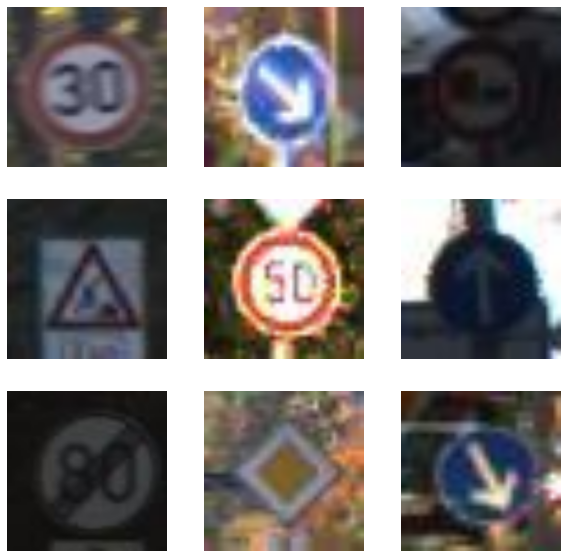

In [ ]:
# Diplay first nine images 
plt.figure(figsize=(10, 10))
for images, labels in dataset_train_224.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

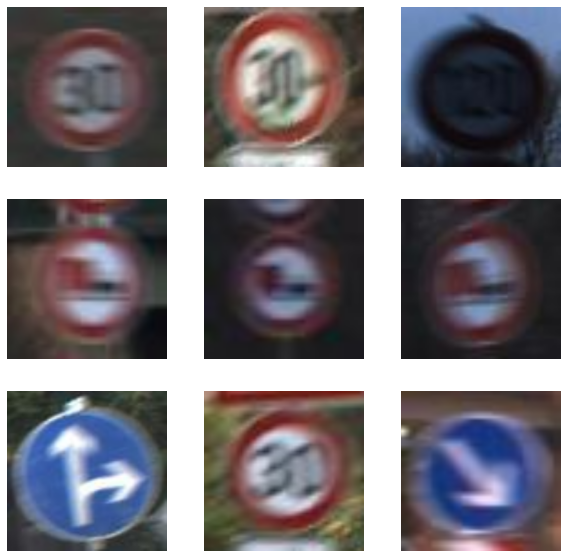

In [ ]:
# Diplay first nine blurry images 
plt.figure(figsize=(10, 10))
for images, labels in blurry_test_224.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## Vision transformer

In [ ]:
num_classes = 43
input_shape = (72, 72, 3)

In [ ]:
#set the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
#Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


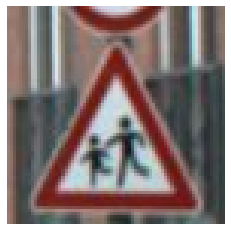

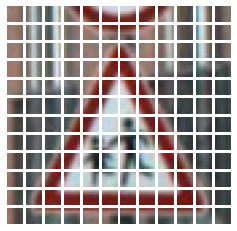

In [ ]:
# display patches for a sample image
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image  = list(dataset_train_72.take(1))[0][0][0]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/100
1569/1569 [==============================] - 75s 42ms/step - loss: 3.3564 - accuracy: 0.1147 - top-5-accuracy: 0.3834 - val_loss: 1.8800 - val_accuracy: 0.4070 - val_top-5-accuracy: 0.7665
Epoch 2/100
1569/1569 [==============================] - 64s 41ms/step - loss: 1.2874 - accuracy: 0.5924 - top-5-accuracy: 0.8822 - val_loss: 0.4278 - val_accuracy: 0.8706 - val_top-5-accuracy: 0.9871
Epoch 3/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.4405 - accuracy: 0.8599 - top-5-accuracy: 0.9857 - val_loss: 0.1632 - val_accuracy: 0.9499 - val_top-5-accuracy: 0.9948
Epoch 4/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.2499 - accuracy: 0.9227 - top-5-accuracy: 0.9929 - val_loss: 0.1111 - val_accuracy: 0.9700 - val_top-5-accuracy: 0.9957
Epoch 5/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.1994 - accuracy: 0.9370 - top-5-accuracy: 0.9951 - val_loss: 0.0891 - val_accuracy: 0.9737 - val_top-5-accuracy: 0.

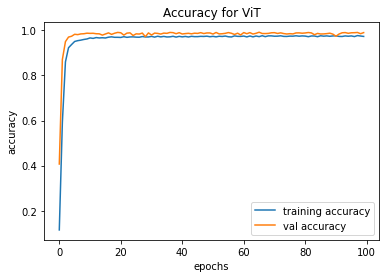

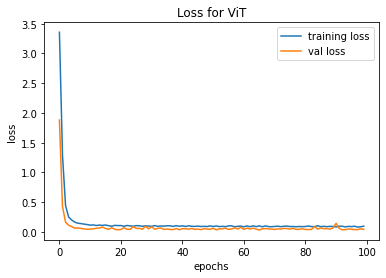

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        dataset_train_norm_72,
        batch_size=256,
        epochs=num_epochs,
        validation_data=dataset_val_norm_72,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(dataset_test_norm_72)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    _, accuracy, top_5_accuracy = model.evaluate(blurry_test_norm_72)
    print(f"Blury accuracy: {round(accuracy * 100, 2)}%")
    return history

start = time.time()
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)
stop = time.time()
print(f"Execution time: {stop - start}s")

# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for ViT')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for ViT')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## VGG16

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# do not need to train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(43, activation='softmax')(x)

In [ ]:
# create a model 
model_VGG16 = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# the structure of the model
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Compilation of the model
model_VGG16.compile(loss='sparse_categorical_crossentropy', optimizer=opt , metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
# Train the Model
start = time.time()
history = model_VGG16.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 48s 25ms/step - loss: 1.2926 - accuracy: 0.6640 - val_loss: 53.5022 - val_accuracy: 0.5526
Epoch 2/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.6510 - accuracy: 0.8208 - val_loss: 68.8883 - val_accuracy: 0.5678
Epoch 3/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.5169 - accuracy: 0.8588 - val_loss: 78.6223 - val_accuracy: 0.5598
Epoch 4/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.4345 - accuracy: 0.8836 - val_loss: 85.6602 - val_accuracy: 0.5706
Epoch 5/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3805 - accuracy: 0.8985 - val_loss: 97.8157 - val_accuracy: 0.5599
Epoch 6/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3499 - accuracy: 0.9068 - val_loss: 104.5188 - val_accuracy: 0.5645
Epoch 7/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3084 - accuracy: 0.9163 - val_

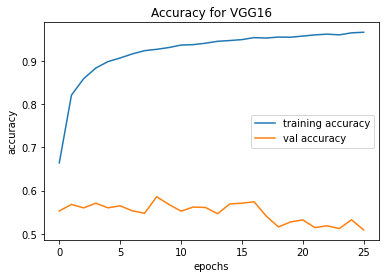

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for VGG16')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

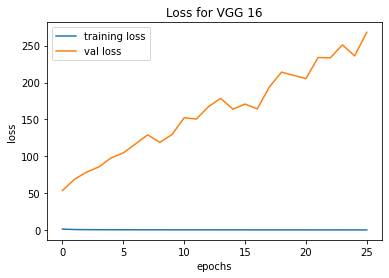

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for VGG 16')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_VGG16.evaluate(dataset_test_norm_224)

395/395 [==============================] - 12s 28ms/step - loss: 2.4026 - accuracy: 0.7481


[2.4026331901550293, 0.7481393218040466]

In [ ]:
# save the model
from tensorflow.keras.models import load_model
model_VGG16.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_VGG16.h5')

In [ ]:
trained_Vgg = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_VGG16.h5')

In [ ]:
trained_Vgg.evaluate(blurry_test_norm_224)

2/2 [==============================] - 1s 478ms/step - loss: 2.1915 - accuracy: 0.7800


[2.1914782524108887, 0.7799999713897705]

## ResNet50

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# do not need to train existing weights
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
prediction = Dense(43, activation='softmax')(x)

In [ ]:
# create a model 
model_ResNet = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# the structure of the model
model_ResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#Compilation of the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_ResNet.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#Train the ResNet Model
start=time.time()
history = model_ResNet.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 37s 22ms/step - loss: 5.7404 - accuracy: 0.2227 - val_loss: 5.5728 - val_accuracy: 0.1983
Epoch 2/100
1569/1569 [==============================] - 33s 21ms/step - loss: 4.5440 - accuracy: 0.3520 - val_loss: 5.3995 - val_accuracy: 0.2840
Epoch 3/100
1569/1569 [==============================] - 33s 21ms/step - loss: 4.2310 - accuracy: 0.4102 - val_loss: 4.9243 - val_accuracy: 0.3237
Epoch 4/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.8346 - accuracy: 0.4611 - val_loss: 5.4637 - val_accuracy: 0.3765
Epoch 5/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.6961 - accuracy: 0.4832 - val_loss: 3.5542 - val_accuracy: 0.4190
Epoch 6/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.5390 - accuracy: 0.5100 - val_loss: 3.2602 - val_accuracy: 0.4674
Epoch 7/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.3616 - accuracy: 0.5313 - val_loss: 4

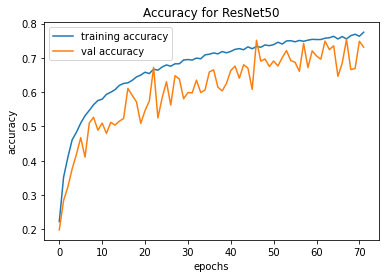

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for ResNet50')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

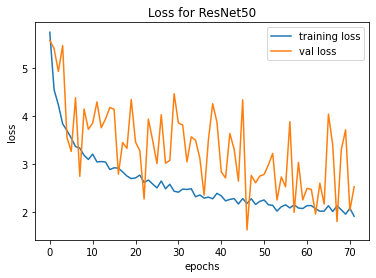

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for ResNet50')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# save the model
model_ResNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_ResNet.h5')

In [ ]:
model_ResNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 23ms/step - loss: 5.2420 - accuracy: 0.6516


[5.242031097412109, 0.6516231298446655]

In [ ]:
trained_ResNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_ResNet.h5')

In [ ]:
trained_ResNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 10s 22ms/step - loss: 5.2420 - accuracy: 0.6516


[5.242031097412109, 0.6516231298446655]

In [ ]:
trained_ResNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 208ms/step - loss: 3.7766 - accuracy: 0.6000


[3.776559352874756, 0.6000000238418579]

## Inception V3

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_InceptionV3 = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model_InceptionV3.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#Train the Inception Model
start=time.time()
history = model_InceptionV3.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 39s 22ms/step - loss: 3.9953 - accuracy: 0.7678 - val_loss: 2.8511 - val_accuracy: 0.8519
Epoch 2/100
1569/1569 [==============================] - 33s 21ms/step - loss: 1.5913 - accuracy: 0.9097 - val_loss: 3.9104 - val_accuracy: 0.8489
Epoch 3/100
1569/1569 [==============================] - 33s 21ms/step - loss: 1.1630 - accuracy: 0.9393 - val_loss: 2.3305 - val_accuracy: 0.9097
Epoch 4/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.9522 - accuracy: 0.9533 - val_loss: 4.0910 - val_accuracy: 0.8782
Epoch 5/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7920 - accuracy: 0.9622 - val_loss: 2.9863 - val_accuracy: 0.9045
Epoch 6/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7199 - accuracy: 0.9673 - val_loss: 2.6632 - val_accuracy: 0.9228
Epoch 7/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.6601 - accuracy: 0.9722 - val_loss: 2

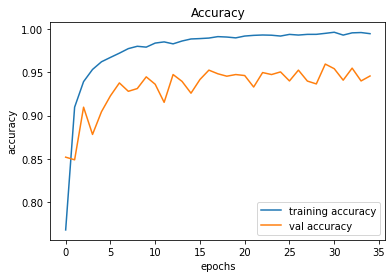

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

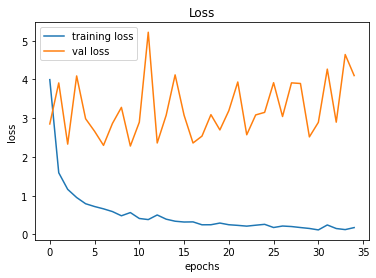

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_InceptionV3.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_InceptionV3.h5')

In [ ]:
model_InceptionV3.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 21ms/step - loss: 32.5210 - accuracy: 0.7826


[32.52099609375, 0.7825811505317688]

In [ ]:
model_InceptionV3.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 20ms/step - loss: 40.1631 - accuracy: 0.6800


[40.1630744934082, 0.6800000071525574]

In [ ]:
trained_Inception = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_InceptionV3.h5')

In [ ]:
trained_Inception.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 20ms/step - loss: 32.5210 - accuracy: 0.7826


[32.52099609375, 0.7825811505317688]

In [ ]:
trained_Inception.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 367ms/step - loss: 40.1631 - accuracy: 0.6800


[40.1630744934082, 0.6800000071525574]

## MobileNet

In [ ]:
from keras.applications import MobileNetV2
mobilenet = MobileNetV2(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_MobileNet = Model(inputs=mobilenet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_MobileNet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# cost and optimization method 
model_MobileNet.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Fit the MobileNet Model
start = time.time()
history = model_MobileNet.fit(dataset_train_norm_224, batch_size=32, validation_data= dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 25s 15ms/step - loss: 4.5966 - accuracy: 0.7872 - val_loss: 2.5009 - val_accuracy: 0.8834
Epoch 2/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.7951 - accuracy: 0.9198 - val_loss: 2.8590 - val_accuracy: 0.8976
Epoch 3/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.3447 - accuracy: 0.9447 - val_loss: 4.6893 - val_accuracy: 0.8765
Epoch 4/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.0852 - accuracy: 0.9582 - val_loss: 3.0648 - val_accuracy: 0.9151
Epoch 5/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.1329 - accuracy: 0.9616 - val_loss: 3.2297 - val_accuracy: 0.9293
Epoch 6/100
1569/1569 [==============================] - 23s 14ms/step - loss: 0.7754 - accuracy: 0.9735 - val_loss: 3.2989 - val_accuracy: 0.9186
Epoch 7/100
1569/1569 [==============================] - 22s 14ms/step - loss: 0.7722 - accuracy: 0.9759 - val_loss: 2

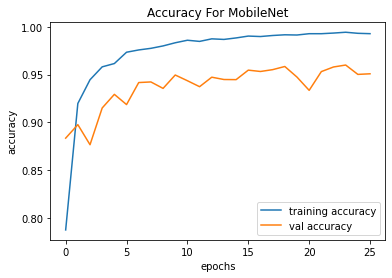

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy For MobileNet')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

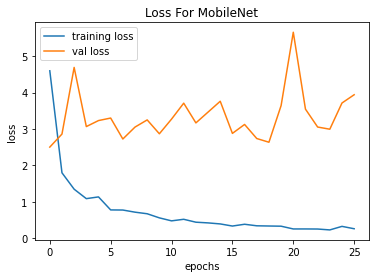

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss For MobileNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
predictions = model_MobileNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 6s 15ms/step - loss: 30.5956 - accuracy: 0.8032


In [ ]:
model_MobileNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 131ms/step - loss: 33.3425 - accuracy: 0.7600


[33.34251403808594, 0.7599999904632568]

In [ ]:
model_MobileNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_MobileNet.h5')

In [ ]:
trained_MobileNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_MobileNet.h5')

In [ ]:
trained_MobileNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 7s 15ms/step - loss: 30.5956 - accuracy: 0.8032


[30.595598220825195, 0.8031670451164246]

In [ ]:
trained_MobileNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 14ms/step - loss: 33.3425 - accuracy: 0.7600


[33.34251403808594, 0.7599999904632568]

## EfficientNet

In [ ]:
from keras.applications import EfficientNetB0
efficientnet = EfficientNetB0(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in efficientnet.layers:
    layer.trainable = False

In [ ]:
# our layers
x = Flatten()(efficientnet.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_EfficientNet = Model(inputs=efficientnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_EfficientNet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [ ]:
# cost and optimization method 
model_EfficientNet.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#fit the EfficientNet model
start = time.time()
history = model_EfficientNet.fit(dataset_train_norm_224, batch_size=32, validation_data= dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 37s 20ms/step - loss: 12.4612 - accuracy: 0.0375 - val_loss: 14.4172 - val_accuracy: 0.0171
Epoch 2/100
1569/1569 [==============================] - 29s 19ms/step - loss: 11.9558 - accuracy: 0.0382 - val_loss: 16.1851 - val_accuracy: 0.0361
Epoch 3/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.2490 - accuracy: 0.0418 - val_loss: 18.4626 - val_accuracy: 0.0062
Epoch 4/100
1569/1569 [==============================] - 29s 18ms/step - loss: 12.0863 - accuracy: 0.0416 - val_loss: 11.5179 - val_accuracy: 0.0667
Epoch 5/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.5942 - accuracy: 0.0417 - val_loss: 15.8288 - val_accuracy: 0.0518
Epoch 6/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.0578 - accuracy: 0.0435 - val_loss: 9.8114 - val_accuracy: 0.0269
Epoch 7/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.2295 - accuracy: 0.0427 -

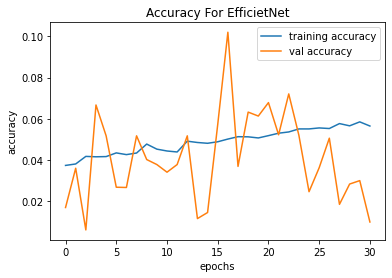

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy For EfficietNet')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

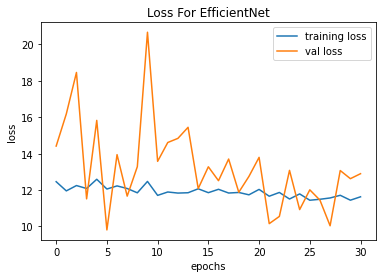

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss For EfficientNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_EfficientNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 8s 20ms/step - loss: 12.6002 - accuracy: 0.0106


[12.600190162658691, 0.010609659366309643]

In [ ]:
model_EfficientNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 147ms/step - loss: 14.5157 - accuracy: 0.0000e+00


[14.515703201293945, 0.0]

In [ ]:
model_EfficientNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_EfficientNet.h5')

In [ ]:
trained_EfficientNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_EfficientNet.h5')

In [ ]:
trained_EfficientNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 20ms/step - loss: 12.6002 - accuracy: 0.0106


[12.600213050842285, 0.010609659366309643]

In [ ]:
trained_EfficientNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 17ms/step - loss: 14.5158 - accuracy: 0.0000e+00


[14.515839576721191, 0.0]